In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
#%matplotlib notebook

from IPython.display import HTML

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.hmm import HMM, HSMM
from ssm.util import find_permutation
from ssm.observations import AutoRegressiveObservations, AutoRegressiveDiagonalNoiseObservations
from ssm.observations import Observations
from ssm.stats import diagonal_gaussian_logpdf


In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

In [4]:
arena_x_max = 320
arena_y_max = 380

In [5]:
arena_center = np.array([arena_x_max/2, arena_y_max/2, arena_x_max/2, arena_y_max/2])

In [6]:
K = 5
D = 4
data = traj29

In [114]:
model1 = HMM(K, D, M=0, 
                 observations='ar')

In [115]:
model1_lls = model1.fit(data, method="em", num_em_iters=100)

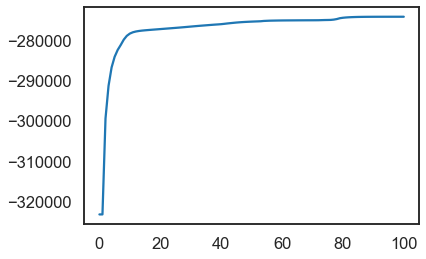

In [117]:
plt.plot(model1_lls)

In [118]:
zs = model1.most_likely_states(data)

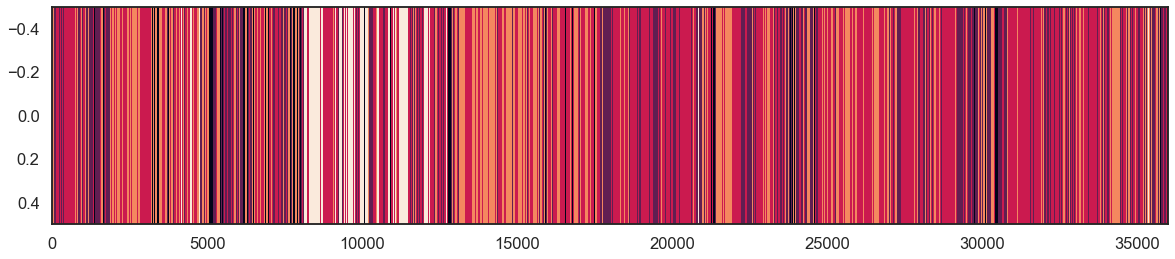

In [119]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(zs[None,slc], aspect="auto")

In [11]:
def k_step_prediction(model, z, data, k=0):
    """
    Conditioned on the most likely hidden states, make the k-step prediction.
    """
    x_predict_arr = []
    if k == 0:
        for t in range(data.shape[0]):
            x_predict = model.observations.sample_x(z[t], data[:t], input=inputs)
            x_predict_arr.append(x_predict)
    else:
        assert k>0
        # neglects t = 0 since there is no history
        for t in range(1,data.shape[0]-k):
            zx_predict = model.sample(k, prefix=(z[t-1:t], data[t-1:t]))
            assert zx_predict[1].shape == (k, 4)
            x_predict = zx_predict[1][k-1]
            x_predict_arr.append(x_predict)
    x_predict_arr = np.array(x_predict_arr)
    return x_predict_arr    

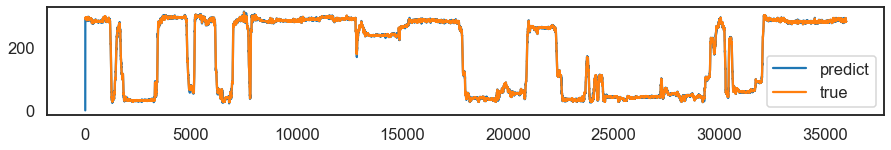

In [121]:
x_predict_arr = k_step_prediction(model1, zs, data)

plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0], label='true')
plt.legend()
plt.show()

In [122]:
sample_z, sample_x = model1.sample(10000)

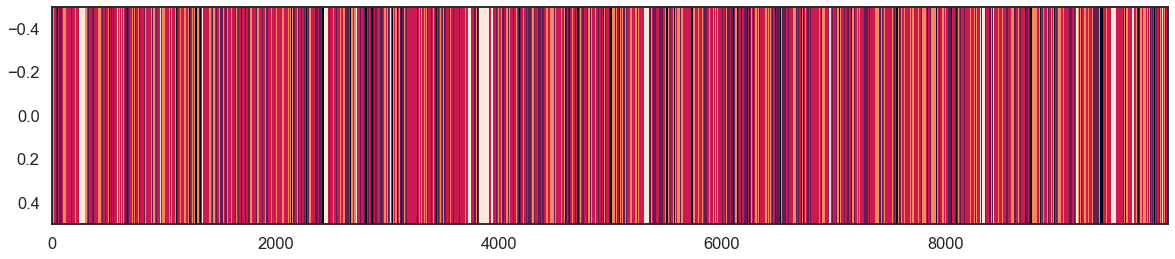

In [123]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(sample_z[None,slc], aspect="auto")

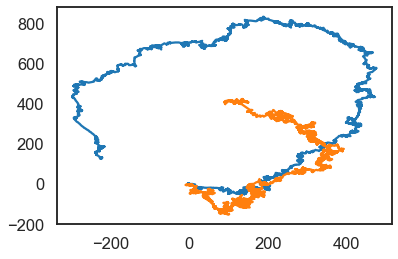

In [124]:
plt.plot(sample_x[:,0], sample_x[:,1])
plt.plot(sample_x[:,2], sample_x[:,3])

In [69]:
def plot_4_traces(data):
    plt.plot(data[:, 0], label='x1')
    plt.plot(data[:, 1], label='y1')
    plt.plot(data[:, 2], label='x2')
    plt.plot(data[:, 3], label='y2')
    plt.legend()

In [27]:
def plot_2_mice(data):
    plt.plot(data[:,0], data[:,1], label='virgin')
    plt.plot(data[:,2], data[:,3], label='mother')
    plt.legend();

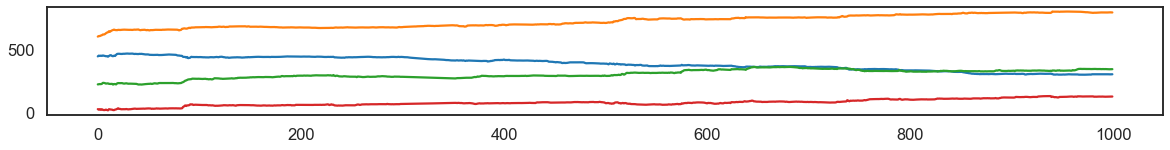

In [127]:
plt.figure(figsize=(20,2))
plot_4_traces(sample_x[5000:6000])

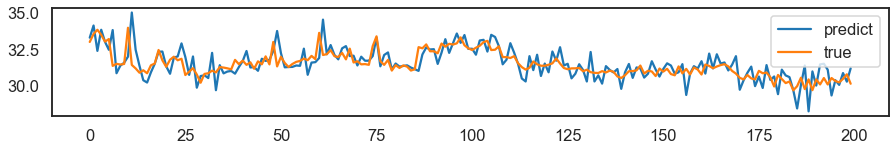

In [131]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[2000:2200,0], label='predict')
plt.plot(data[2000:2200,0], label='true')
plt.legend()
plt.show()

## try to increase the lags

In [129]:
observation = AutoRegressiveObservations(K=K, D=D, lags=20)

model2 = HMM(K, D, M=0, 
                 observations=observation)

In [130]:
model2_lls = model2.fit(data, method="em", num_em_iters=100)

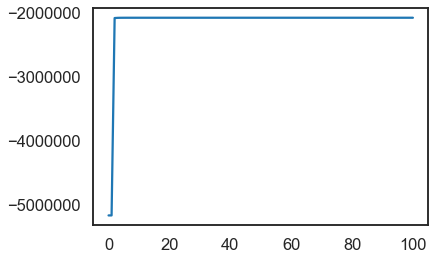

In [98]:
plt.plot(model2_lls)

In [99]:
z2 = model2.most_likely_states(data)

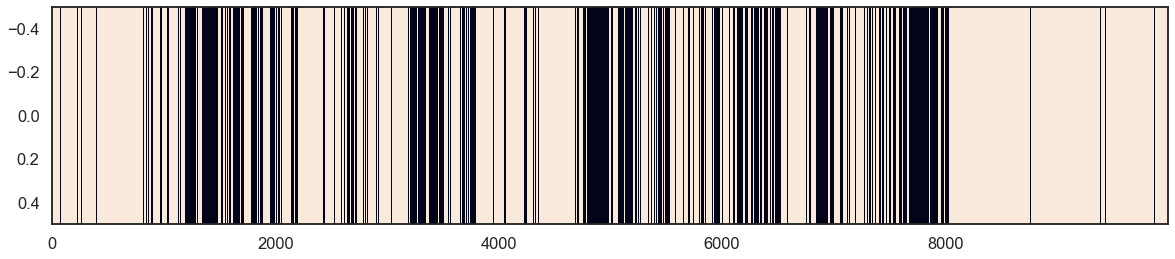

In [100]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(zs[None,slc], aspect="auto")

In [103]:
x_predict_arr_2 = k_step_prediction(model2, z2, data)

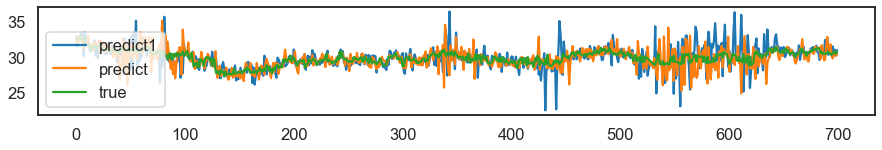

In [109]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[2100:2800,0], label='predict1')
plt.plot(x_predict_arr_2[2100:2800,0], label='predict')
plt.plot(data[2100:2800,0], label='true')
plt.legend()
plt.show()

# now, try video clip 20

In [7]:
K = 5
D = 4
data = rendered_data[20]

In [8]:
model = HMM(K, D, M=0, observations='ar')

In [9]:
model_lls = model.fit(data, method="em", num_em_iters=100)

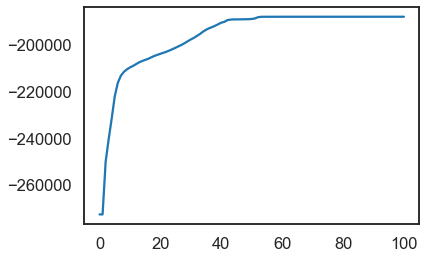

In [10]:
plt.plot(model_lls)

In [12]:
zs = model.most_likely_states(data)

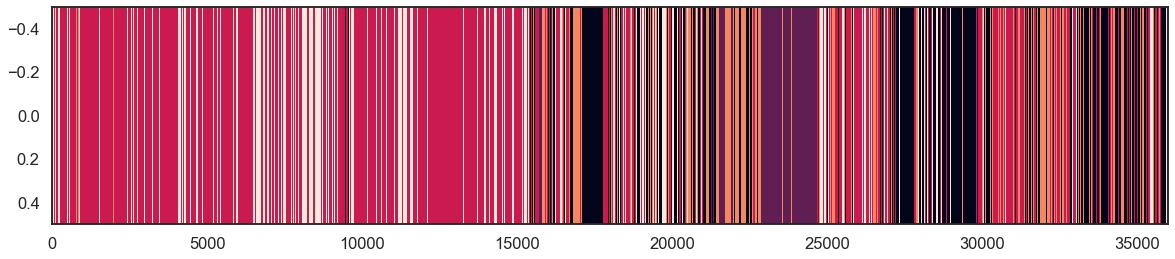

In [13]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(zs[None,slc], aspect="auto")

In [16]:
inputs = np.zeros(data.shape[0],)
x_predict_arr = k_step_prediction(model, zs, data)


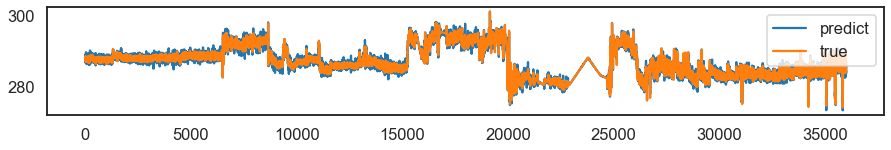

In [19]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[1:,0], label='predict')
plt.plot(data[1:,0], label='true')
plt.legend()
plt.show()

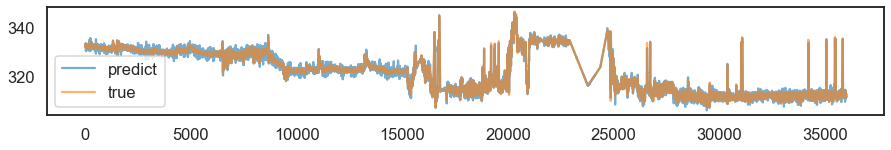

In [24]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[1:,1], label='predict', alpha=0.6)
plt.plot(data[1:,1], label='true', alpha=0.6)
plt.legend()
plt.show()

# check samples

In [39]:
sample_z, sample_x = model.sample(36000)

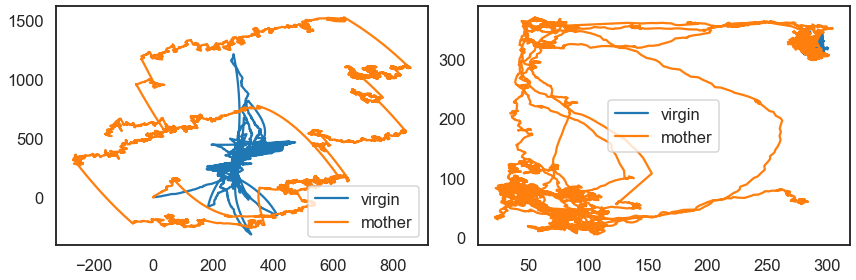

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_2_mice(sample_x)
plt.subplot(1,2,2)
plot_2_mice(data)
plt.tight_layout()

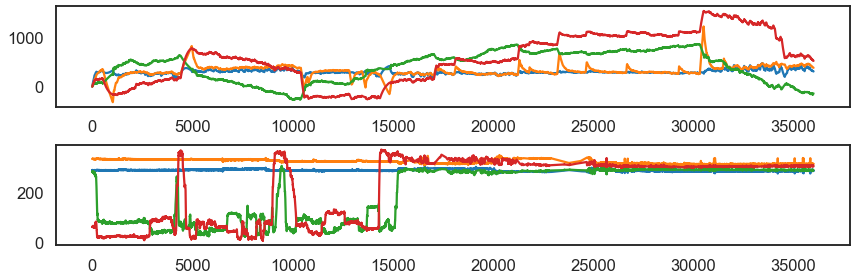

In [43]:
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plot_4_traces(sample_x)
plt.subplot(2,1,2)
plot_4_traces(data)
plt.tight_layout()

ARHMM with Gaussian observation cannot capture the still behavior of the virgin mouse.

# try to learn separate models

In [46]:
data_v = data[:,0:2]
data_m = data[:, 2:4]

In [47]:
model_v = HMM(2, 2, M=0, observations='ar')

In [48]:
model_lls_v = model_v.fit(data_v, method="em", num_em_iters=100)

In [49]:
model_m = HMM(2, 2, M=0, observations='ar')

In [76]:
model_m.observations

In [50]:
model_lls_m = model_m.fit(data_m, method="em", num_em_iters=100)

# check prediction

In [51]:
zs_v = model_v.most_likely_states(data_v)
zs_m = model_m.most_likely_states(data_m)

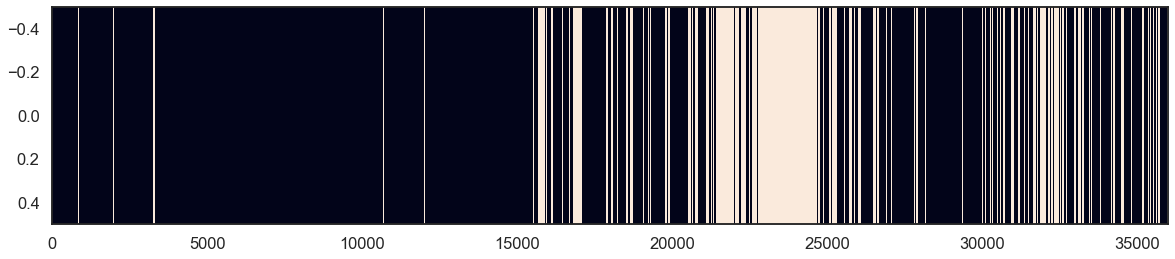

In [52]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(zs_v[None,slc], aspect="auto")

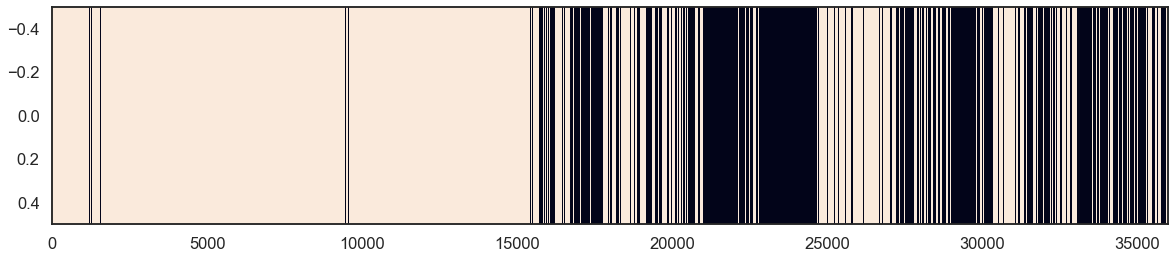

In [53]:
slc = slice(0,-1)

plt.figure(figsize=(20,4))
plt.imshow(zs_m[None,slc], aspect="auto")

In [54]:
inputs_v = np.zeros(data_v.shape[0],)
x_predict_arr_v = k_step_prediction(model_v, zs_v, data_v)

inputs_m = np.zeros(data_m.shape[0],)
x_predict_arr_m = k_step_prediction(model_m, zs_m, data_m)

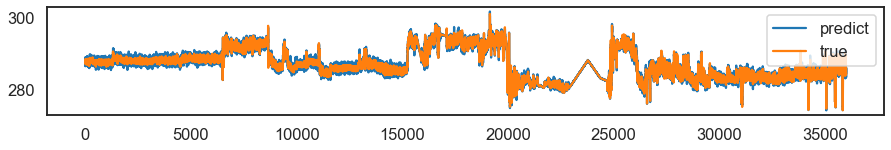

In [55]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr_v[1:,0], label='predict')
plt.plot(data_v[1:,0], label='true')
plt.legend()
plt.show()

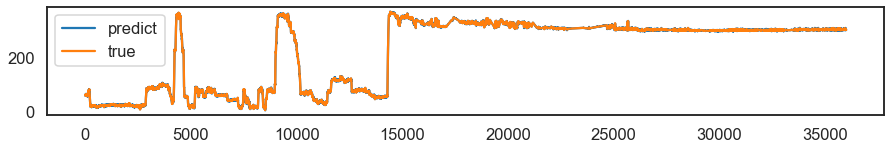

In [57]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr_m[1:,1], label='predict')
plt.plot(data_m[1:,1], label='true')
plt.legend()
plt.show()

# check samples

In [58]:
sample_z_v, sample_x_v = model_v.sample(36000)

In [61]:
sample_z_m, sample_x_m = model_m.sample(36000)

In [64]:
sample_vm = np.concatenate((sample_x_v, sample_x_m), axis=1)

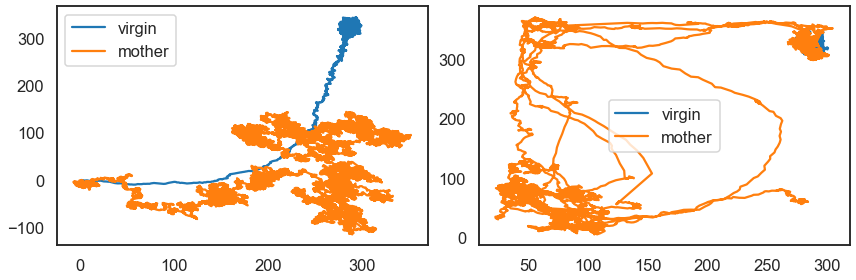

In [75]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_2_mice(sample_vm)

plt.subplot(1,2,2)
plot_2_mice(data)
plt.tight_layout()

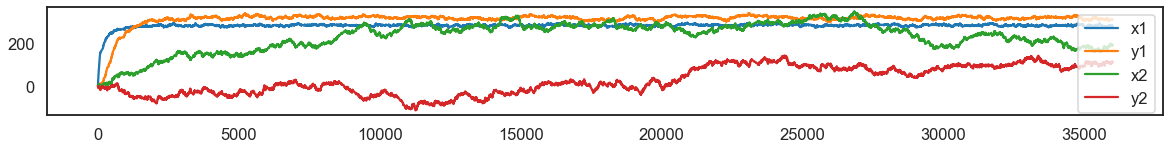

In [70]:
plt.figure(figsize=(20,2))
plot_4_traces(sample_vm)

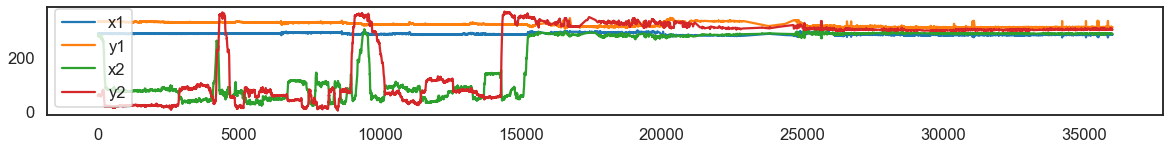

In [71]:
plt.figure(figsize=(20,2))
plot_4_traces(data)